In [1]:
import os
import time
import json
import argparse
from typing import List, Dict

from tqdm import tqdm
import tensorflow as tf

from constants import *
from serializable import *
from argtypes import *
from logger import *
from utils import *
from tensorflow_utils import *

In [2]:
char2index: Dict[str, int] = {}

In [3]:
def list_datasets(datasets: List[Dataset]):
    for idx, ds in enumerate(datasets):
        print(f'{idx} - {ds.name}')


def process_image_data(image_data, channels: int):
    image = tf.image.decode_png(image_data, channels=channels)
    image = tf.cast(image, tf.float32)
    image = image / 255.0
    return image


def process_record(record):
    # TensorFlow is implemented in C/C++ and Python wrapper is generated
    # at building time so typing is nearly non-existence when working
    # with TensorFlow.
    image_data = record[TFRSerDes.IMAGE_KEY].numpy()
    # image_width = record[TFRSerDes.IMAGE_WIDTH_KEY]
    # image_height = record[TFRSerDes.IMAGE_HEIGHT_KEY]
    image_depth = record[TFRSerDes.IMAGE_DEPTH_KEY].numpy()

    # TODO AttributeError: 'Tensor' object has no attribute 'numpy'
    # encoded_char: bytes = record[TFRSerDes.CHARACTER_KEY].numpy()
    # char = encoded_char.decode(TFRSerDes.ENCODING)

    # TODO TensorFlow is building execution graph so external references
    # are not allowed.
    # We may have to train the model in Jupyter Notebook where most of
    # TensorFlow features are executed eagerly.
    char = record[TFRSerDes.CHARACTER_KEY].numpy().decode(TFRSerDes.ENCODING)

    label = char2index[char]

    return process_image_data(image_data, image_depth), label

In [4]:
datasets_dir = DATASETS_DIR
datasets = []
dataset_dirs = os.listdir(datasets_dir)
dataset_dirs

['1587195782-hiragana', '1587211071-hiragana', 'hiragana', 'jouyou_kanji']

In [5]:
name = dataset_dirs[2]
name

'hiragana'

In [6]:
dataset_dir = os.path.join(datasets_dir, name)

metadata_filepath = os.path.join(dataset_dir, METADATA_FILENAME)
serialized_dataset_filepath = os.path.join(dataset_dir, SERIALIZED_DATASET_FILENAME)

json_obj = json.load(open(
    metadata_filepath,
    mode='r',
    encoding='utf-8',
))

metadata = DatasetMetadata.parse_obj(json_obj)

dataset = Dataset(
    name=name,
    path=dataset_dir,
    metadata_filepath=metadata_filepath,
    serialized_dataset_filepath=serialized_dataset_filepath,
    metadata=metadata,
)

In [7]:
ds = dataset
optimizer = 'adam'
loss = 'sparse_categorial_crossentropy'
epochs = 10

In [8]:
char2index = {}
for i in range(len(ds.metadata.labels)):
    char2index[ds.metadata.labels[i]] = i
char2index

{'あ': 0,
 'い': 1,
 'う': 2,
 'え': 3,
 'お': 4,
 'か': 5,
 'き': 6,
 'く': 7,
 'け': 8,
 'こ': 9,
 'さ': 10,
 'し': 11,
 'す': 12,
 'せ': 13,
 'そ': 14,
 'た': 15,
 'ち': 16,
 'つ': 17,
 'て': 18,
 'と': 19,
 'な': 20,
 'に': 21,
 'ぬ': 22,
 'ね': 23,
 'の': 24,
 'ま': 25,
 'み': 26,
 'む': 27,
 'め': 28,
 'も': 29,
 'は': 30,
 'ひ': 31,
 'ふ': 32,
 'へ': 33,
 'ほ': 34,
 'や': 35,
 'ゆ': 36,
 'よ': 37,
 'ら': 38,
 'り': 39,
 'る': 40,
 'れ': 41,
 'ろ': 42,
 'わ': 43,
 'ん': 44}

In [9]:
dataset_filepath = os.path.join(ds.path, INSPECTED_DATASET_FILENAME)
if not os.path.exists(dataset_filepath):
    warn(f'Cannot find inspected dataset!')
dataset_filepath

'datasets\\hiragana\\inspected-dataset.tfrecord'

In [10]:
raw_dataset = tf.data.TFRecordDataset(dataset_filepath)
raw_dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

In [11]:
train_dataset = raw_dataset.map(TFRSerDes.read_record)
train_dataset

<MapDataset shapes: {CHARACTER: (), DEPTH: (), DESCRIPTION: (), FONT_NAME: (), FONT_SIZE: (), HASH: (), HEIGHT: (), PNG_IMAGE: (), WIDTH: ()}, types: {CHARACTER: tf.string, DEPTH: tf.int64, DESCRIPTION: tf.string, FONT_NAME: tf.string, FONT_SIZE: tf.int64, HASH: tf.string, HEIGHT: tf.int64, PNG_IMAGE: tf.string, WIDTH: tf.int64}>

In [12]:
# for record in train_dataset:
#     break

In [13]:
# record[TFRSerDes.IMAGE_KEY]

In [14]:
train_dataset = map(process_record, train_dataset)
train_dataset

In [15]:
train_dataset = list(train_dataset)

In [16]:
len(train_dataset)

2070

In [18]:
record = train_dataset[0]
record

(<tf.Tensor: shape=(64, 64, 1), dtype=float32, numpy=
 array([[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        ...,
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]], dtype=float32)>,
 0)

In [19]:
len(record)

2

In [20]:
record[1]

0

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import PIL

In [27]:
num_samples = 100
samples = []
width = 64
height = 64

for i in range(num_samples):
    sample = np.random.randint(low=0, high=255+1, size=(height, width))
    sample = sample.astype(np.uint8)
    samples.append(sample)

In [28]:
sample

array([[  2, 191, 109, ...,  54, 160,  13],
       [ 27, 162, 198, ...,  63,  34, 159],
       [ 27, 125, 103, ..., 249,  53, 204],
       ...,
       [217, 228,  38, ..., 194, 238,  52],
       [250,  20, 107, ...,  63, 142, 127],
       [201, 195,  56, ..., 145, 172,  30]], dtype=uint8)

In [29]:
sample.dtype

dtype('uint8')

In [30]:
sample.shape

(64, 64)

In [33]:
import io
from tqdm import tqdm

In [34]:
encoded_samples = []

for sample in tqdm(samples):
    # https://pillow.readthedocs.io/en/3.1.x/handbook/concepts.html#concept-modes
    # L for grayscale
    pil_image = PIL.Image.fromarray(sample, mode='L')
    bs = io.BytesIO()
    pil_image.save(bs, format='PNG')
    encoded_image = bs.getvalue()
    encoded_samples.append(encoded_image)

100%|████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 216.49it/s]


In [35]:
len(encoded_image)

4228

In [41]:
num_tests = 100_000

# Decode PNG with OpenCV

In [42]:
for i in tqdm(range(num_tests)):
    idx = i % len(encoded_samples)
    encoded_sample = encoded_samples[idx]
    buf = np.frombuffer(encoded_sample, dtype=np.uint8)
    image = cv2.imdecode(buf, cv2.IMREAD_UNCHANGED)

100%|████████████████████████████████████████████████████████████████████| 100000/100000 [00:03<00:00, 29319.35it/s]


In [45]:
image.shape

(64, 64)

In [46]:
image.dtype

dtype('uint8')

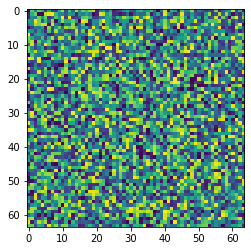

In [44]:
plt.imshow(image)

# Decode PNG with pillow

In [48]:
for i in tqdm(range(num_tests)):
    idx = i % len(encoded_samples)
    encoded_sample = encoded_samples[idx]
    stream = io.BytesIO(encoded_sample)
    pil_image = PIL.Image.open(stream)
    image = np.array(pil_image, dtype=np.uint8)

100%|█████████████████████████████████████████████████████████████████████| 100000/100000 [00:10<00:00, 9799.94it/s]


In [49]:
image.shape

(64, 64)

In [50]:
image.dtype

dtype('uint8')

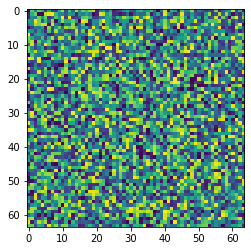

In [51]:
plt.imshow(image)

In [52]:
_image = image.reshape([height, width, 1])
_image.shape

(64, 64, 1)

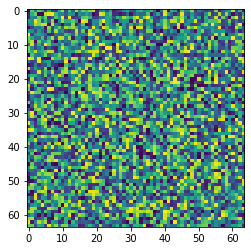

In [53]:
plt.imshow(_image[:,:,0])